# Universal Impulse Current Calculator

Lightning impulse current calculations based on my diss (see 'sources').

## Features
- **Heidler Function** (Equation D.1) - Models natural lightning currents
- **Double-Exponential Function** (Equation D.2) - Models laboratory impulse currents
- **Standard Impulse Types**: 
  - PEB = 10/350µs (partial lightning current, Type 1 / LPL-related)
  - SEB/SC = 8/20µs (surge current, Type 2 / switching/surge-related)
  - NEB = 1/200µs
  - NFB = 0.25/100µs
- **Calculated Parameters**: Specific Energy (W/R), Charge (Q), Peak Steepness (di/dt)_max

## References
- IEC 62305-1 (DIN EN 62305-1) - Lightning Protection Standard
- IEC 61400-24 - Wind Turbine Lightning Protection
- Parameter tables from Appendix D of my thesis

In [139]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

# Configure matplotlib for inline display in Jupyter
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Parameter Database

### Table D.1: Parameters for Lightning Impulse Current Functions
Time constants τ₁, τ₂ (in µs) and correction factors η for different impulse types.

In [ ]:
# Parameter database from Table D.1 and D.2 of my dissertation

# Table D.1: Time constants for impulse current functions (τ in µs)
IMPULSE_PARAMS = {
    'PEB': {  # Positive First Stroke (10/350 µs)
        'name': 'Positive First Stroke (PEB)',
        'designation': '10/350 µs',
        'description': 'Partial lightning current, Type 1 / LPL-related',
        'heidler': {
            'tau1': 18.8e-6,      # Front time constant (s)
            'tau2': 485e-6,       # Tail time constant (s)
            'eta': 0.93,          # Correction factor
            'n': 10               # Steepness factor
        },
        'double_exp': {
            'tau1': 4.064e-6,     # Front time constant (s)
            'tau2': 470.107e-6,   # Tail time constant (s)
            'eta': 0.951          # Correction factor
        }
    },
    'NEB': {  # Negative First Stroke (1/200 µs)
        'name': 'Negative First Stroke (NEB)',
        'designation': '1/200 µs',
        'heidler': {
            'tau1': 1.826e-6,
            'tau2': 285e-6,
            'eta': 0.988,
            'n': 10
        },
        'double_exp': {
            'tau1': 0.374e-6,
            'tau2': 284.328e-6,
            'eta': 0.99
        }
    },
    'NFB': {  # Negative Subsequent Stroke (0.25/100 µs)
        'name': 'Negative Subsequent Stroke (NFB)',
        'designation': '0.25/100 µs',
        'heidler': {
            'tau1': 0.454e-6,
            'tau2': 143.4e-6,
            'eta': 0.993,
            'n': 10
        },
        'double_exp': {
            'tau1': 0.092e-6,
            'tau2': 143.134e-6,
            'eta': 0.995
        }
    },
    'SEB': {  # Switching Event / Surge current (8/20 µs)
        'name': 'Surge Current (SEB)',
        'designation': '8/20 µs',
        'description': 'Switching Event / Surge current, Type 2 / switching/surge-related',
        'damped_sine': {
            'tau': 24e-6,         # Decay time constant (s)
            'omega': 120023,      # Angular frequency (rad/s)
            'eta': 0.615          # Correction factor
        }
    },
    'SC': {  # Surge Current (8/20 µs) - alias for SEB
        'name': 'Surge Current (SC)',
        'designation': '8/20 µs',
        'description': 'Surge Current, Type 2 / switching/surge-related',
        'damped_sine': {
            'tau': 24e-6,         # Decay time constant (s)
            'omega': 120023,      # Angular frequency (rad/s)
            'eta': 0.615          # Correction factor
        }
    }
}

# Table D.2: Reference values for LPL I (Lightning Protection Level I)
REFERENCE_VALUES = {
    'PEB': {
        'T1_T2': '10/350 µs',
        'I_peak': 200e3,          # Peak current (A)
        'Q': 100,                 # Charge (C)
        'W_R': 10e6,              # Specific energy (J/Ω)
        'I_T1': 20e3,             # Average steepness I/T1 (A/µs -> A/s)
        'di_dt_max': 27.3e3,      # Maximum steepness (kA/µs -> A/s)
        'k': 1.365                # Steepness factor
    },
    'NEB': {
        'T1_T2': '1/200 µs',
        'I_peak': 100e3,
        'Q': 28.7,
        'W_R': 1.44e6,
        'I_T1': 100e3,
        'di_dt_max': 139e3,
        'k': 1.39
    },
    'NFB': {
        'T1_T2': '0.25/100 µs',
        'I_peak': 50e3,
        'Q': 7.2,
        'W_R': 0.18e6,
        'I_T1': 200e3,
        'di_dt_max': 279e3,
        'k': 1.395
    },
    'SEB': {
        'T1_T2': '8/20 µs',
        'I_peak': 10e3,           # Typical SPD test current
        'Q': 5,
        'W_R': 0.05e6,
        'I_T1': 1.25e3,
        'di_dt_max': 1.95e3,
        'k': 1.561
    },
    'SC': {
        'T1_T2': '8/20 µs',
        'I_peak': 10e3,           # Typical SPD test current
        'Q': 5,
        'W_R': 0.05e6,
        'I_T1': 1.25e3,
        'di_dt_max': 1.95e3,
        'k': 1.561
    }
}

print("Parameter database initialized successfully!")
print(f"Available impulse types: {list(IMPULSE_PARAMS.keys())}")
print("Note: 'SC' is an alias for 'SEB' (both represent 8/20 µs surge current)")

Parameter database initialized successfully!
Available impulse types: ['PEB', 'NEB', 'NFB', '8/20']


## 2. Correction Factor Calculation Functions

### Heidler Function η:
$$\eta = \exp\left(-\frac{\tau_1}{\tau_2} \cdot \left(n \cdot \frac{\tau_2}{\tau_1}\right)^{\frac{1}{n+1}}\right)$$

### Double-Exponential Function η:
$$\eta = \left(\frac{1}{\tau_1} - \frac{1}{\tau_2}\right) \cdot \left(\frac{\tau_2^{\tau_1}}{\tau_1^{\tau_2}}\right)^{\frac{1}{\tau_1 - \tau_2}}$$

In [141]:
def calculate_eta_heidler(tau1, tau2, n=10):
    """
    Calculate correction factor η for Heidler function.
    
    Parameters:
    -----------
    tau1 : float
        Front time constant (seconds)
    tau2 : float
        Tail time constant (seconds)
    n : int
        Steepness factor (default: 10)
    
    Returns:
    --------
    float : Correction factor η
    """
    exponent = -(tau1/tau2) * (n * tau2/tau1)**(1/(n+1))
    eta = np.exp(exponent)
    return eta


def calculate_eta_double_exp(tau1, tau2):
    """
    Calculate correction factor η for double-exponential function.
    
    Parameters:
    -----------
    tau1 : float
        Front time constant (seconds)
    tau2 : float
        Tail time constant (seconds)
    
    Returns:
    --------
    float : Correction factor η
    """
    term1 = 1/tau1 - 1/tau2
    term2 = (tau2**tau1 / tau1**tau2)**(1/(tau1 - tau2))
    eta = term1 * term2
    return eta


# Verify calculations against table values
print("Verification of η calculations:")
print("\nHeidler Function (see my diss):")
for impulse_type in ['PEB', 'NEB', 'NFB']:
    params = IMPULSE_PARAMS[impulse_type]['heidler']
    eta_calc = calculate_eta_heidler(params['tau1'], params['tau2'], params['n'])
    eta_table = params['eta']
    print(f"{impulse_type}: Calculated η = {eta_calc:.4f}, Table value = {eta_table:.4f}, Difference = {abs(eta_calc - eta_table):.6f}")

print("\nDouble-Exponential Function:")
for impulse_type in ['PEB', 'NEB', 'NFB']:
    params = IMPULSE_PARAMS[impulse_type]['double_exp']
    eta_calc = calculate_eta_double_exp(params['tau1'], params['tau2'])
    eta_table = params['eta']
    print(f"{impulse_type}: Calculated η = {eta_calc:.4f}, Table value = {eta_table:.4f}, Difference = {abs(eta_calc - eta_table):.6f}")

Verification of η calculations:

Heidler Function (see my diss):
PEB: Calculated η = 0.9378, Table value = 0.9300, Difference = 0.007801
NEB: Calculated η = 0.9876, Table value = 0.9880, Difference = 0.000424
NFB: Calculated η = 0.9934, Table value = 0.9930, Difference = 0.000435

Double-Exponential Function:
PEB: Calculated η = 0.9511, Table value = 0.9510, Difference = 0.000124
NEB: Calculated η = 0.9900, Table value = 0.9900, Difference = 0.000003
NFB: Calculated η = 0.9946, Table value = 0.9950, Difference = 0.000356


## 3. Current Waveform Generator Functions

### Heidler Function (Equation D.1):
$$i_B^H(t) = \frac{\bar{I}}{\eta} \cdot \frac{\left(\frac{t}{\tau_1}\right)^n}{1 + \left(\frac{t}{\tau_1}\right)^n} \cdot e^{-\frac{t}{\tau_2}}$$

### Double-Exponential Function (Equation D.2):
$$i_B^{d*}(t) = \frac{\bar{I}}{\eta} \left(e^{-\frac{t}{\tau_2}} - e^{-\frac{t}{\tau_1}}\right)$$

### Damped Sine Wave (for SEB/SC - 8/20 µs):
$$i(t) = \frac{\bar{I}}{\eta} \cdot e^{-\frac{t}{\tau}} \cdot \sin(\omega t)$$

In [ ]:
def heidler_function(t, I_peak, tau1, tau2, eta, n=10):
    """
    Calculate current using Heidler function.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    I_peak : float
        Peak current (Amperes)
    tau1 : float
        Front time constant (seconds)
    tau2 : float
        Tail time constant (seconds)
    eta : float
        Correction factor
    n : int
        Steepness factor (default: 10)
    
    Returns:
    --------
    array : Current values (Amperes)
    """
    t_ratio = t / tau1
    numerator = t_ratio**n
    denominator = 1 + t_ratio**n
    exponential = np.exp(-t / tau2)
    
    current = (I_peak / eta) * (numerator / denominator) * exponential
    
    # Normalize to exact peak current
    actual_peak = np.max(current)
    if actual_peak > 0:
        current = current * (I_peak / actual_peak)
    
    return current


def double_exp_function(t, I_peak, tau1, tau2, eta):
    """
    Calculate current using double-exponential function.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    I_peak : float
        Peak current (Amperes)
    tau1 : float
        Front time constant (seconds)
    tau2 : float
        Tail time constant (seconds)
    eta : float
        Correction factor
    
    Returns:
    --------
    array : Current values (Amperes)
    """
    current = (I_peak / eta) * (np.exp(-t / tau2) - np.exp(-t / tau1))
    
    # Normalize to exact peak current
    actual_peak = np.max(current)
    if actual_peak > 0:
        current = current * (I_peak / actual_peak)
    
    return current


def damped_sine_function(t, I_peak, tau, omega, eta):
    """
    Calculate current using damped sine wave (for SEB/SC - 8/20 µs impulse).
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    I_peak : float
        Peak current (Amperes)
    tau : float
        Decay time constant (seconds)
    omega : float
        Angular frequency (rad/s)
    eta : float
        Correction factor
    
    Returns:
    --------
    array : Current values (Amperes)
    """
    current = (I_peak / eta) * np.exp(-t / tau) * np.sin(omega * t)
    
    # Normalize to exact peak current
    actual_peak = np.max(current)
    if actual_peak > 0:
        current = current * (I_peak / actual_peak)
    
    return current


def generate_time_array(duration, dt):
    """
    Generate time array for simulation.
    
    Parameters:
    -----------
    duration : float
        Total simulation duration (seconds)
    dt : float
        Time step (seconds)
    
    Returns:
    --------
    array : Time values (seconds)
    """
    return np.arange(0, duration, dt)


print("Current waveform generator functions defined successfully!")

Current waveform generator functions defined successfully!


## 4. Parameter Calculation Functions

Calculate IEC 62305-1 parameters:
- **Specific Energy (W/R)**: $\int i^2(t) dt$ [J/Ω]
- **Charge (Q)**: $\int i(t) dt$ [C]
- **Maximum Steepness**: $(di/dt)_{max} = k \cdot \frac{\bar{I}}{T_1}$ [A/s]

In [ ]:
def calculate_specific_energy(t, i):
    """
    Calculate specific energy W/R = integral of i²(t)dt.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    i : array-like
        Current array (Amperes)
    
    Returns:
    --------
    float : Specific energy (J/Ω)
    """
    i_squared = i**2
    # Use trapezoid for NumPy 2.0+ compatibility (trapz was deprecated)
    try:
        energy = np.trapezoid(i_squared, t)
    except AttributeError:
        energy = np.trapz(i_squared, t)  # Fallback for older NumPy
    return energy


def calculate_charge(t, i, use_abs=False):
    """
    Calculate charge Q = integral of i(t)dt.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    i : array-like
        Current array (Amperes)
    use_abs : bool
        If True, calculate integral of |i(t)| for bipolar waveforms (SEB/SC - 8/20 µs)
    
    Returns:
    --------
    float : Charge (Coulombs)
    """
    if use_abs:
        # For bipolar waveforms, integrate absolute value
        i_to_integrate = np.abs(i)
    else:
        i_to_integrate = i
    
    # Use trapezoid for NumPy 2.0+ compatibility (trapz was deprecated)
    try:
        charge = np.trapezoid(i_to_integrate, t)
    except AttributeError:
        charge = np.trapz(i_to_integrate, t)  # Fallback for older NumPy
    return charge


def calculate_max_steepness(t, i, method='numerical'):
    """
    Calculate maximum current steepness (di/dt)_max.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    i : array-like
        Current array (Amperes)
    method : str
        'numerical' for numerical differentiation
    
    Returns:
    --------
    tuple : (max_steepness, time_of_max) in (A/s, seconds)
    """
    # Calculate derivative
    di_dt = np.gradient(i, t)
    
    # Find maximum
    max_idx = np.argmax(di_dt)
    max_steepness = di_dt[max_idx]
    time_of_max = t[max_idx]
    
    return max_steepness, time_of_max


def calculate_all_parameters(t, i, impulse_type=None):
    """
    Calculate all IEC parameters for a given current waveform.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    i : array-like
        Current array (Amperes)
    impulse_type : str, optional
        Type of impulse for reference comparison
    
    Returns:
    --------
    dict : Dictionary containing all calculated parameters
    """
    results = {}
    
    # Peak current
    results['I_peak'] = np.max(i)
    results['I_peak_kA'] = results['I_peak'] / 1e3
    results['t_peak'] = t[np.argmax(i)]
    
    # Specific energy
    results['W_R'] = calculate_specific_energy(t, i)
    results['W_R_MJ'] = results['W_R'] / 1e6
    results['W_R_kJ'] = results['W_R'] / 1e3
    
    # Charge (use abs for bipolar waveforms like SEB/SC - 8/20 µs)
    use_abs = (impulse_type in ['SEB', 'SC'])
    results['Q'] = calculate_charge(t, i, use_abs=use_abs)
    
    # Maximum steepness
    results['di_dt_max'], results['t_di_dt_max'] = calculate_max_steepness(t, i)
    results['di_dt_max_kA_us'] = results['di_dt_max'] / 1e9  # Convert to kA/µs
    
    # Add reference values if impulse type is provided
    if impulse_type and impulse_type in REFERENCE_VALUES:
        ref = REFERENCE_VALUES[impulse_type]
        results['ref_I_peak'] = ref['I_peak']
        results['ref_W_R'] = ref['W_R']
        results['ref_Q'] = ref['Q']
        results['ref_di_dt_max'] = ref['di_dt_max']
        
        # Calculate deviations
        results['I_peak_deviation_%'] = (results['I_peak'] - ref['I_peak']) / ref['I_peak'] * 100
        results['W_R_deviation_%'] = (results['W_R'] - ref['W_R']) / ref['W_R'] * 100
        results['Q_deviation_%'] = (results['Q'] - ref['Q']) / ref['Q'] * 100
    
    return results


print("Parameter calculation functions defined successfully!")

Parameter calculation functions defined successfully!


## 5. Visualization Functions

In [144]:
def plot_current_waveform(t, i, title="Current Waveform", params=None, show_derivative=False):
    """
    Plot current waveform with annotations.
    
    Parameters:
    -----------
    t : array-like
        Time array (seconds)
    i : array-like
        Current array (Amperes)
    title : str
        Plot title
    params : dict, optional
        Calculated parameters to display
    show_derivative : bool
        Whether to show derivative plot
    """
    if show_derivative:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
    
    # Convert time to microseconds for plotting
    t_us = t * 1e6
    i_kA = i / 1e3
    
    # Plot current
    ax1.plot(t_us, i_kA, 'b-', linewidth=2, label='Current')
    ax1.set_ylabel('Current (kA)', fontsize=12, fontweight='bold')
    ax1.set_title(title, fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xlabel('Time (µs)', fontsize=12, fontweight='bold')
    
    # Add parameter text box (without peak markers)
    if params:
        # Smart display of energy: use kJ/Ω if < 1 MJ/Ω, otherwise MJ/Ω
        if params['W_R_MJ'] < 1.0:
            energy_str = f"Specific Energy: {params['W_R_kJ']:.2f} kJ/Ω"
        else:
            energy_str = f"Specific Energy: {params['W_R_MJ']:.3f} MJ/Ω"
        
        textstr = f"Peak Current: {params['I_peak_kA']:.2f} kA\n"
        textstr += energy_str + "\n"
        textstr += f"Charge: {params['Q']:.2f} C\n"
        textstr += f"Max Steepness: {params['di_dt_max_kA_us']:.1f} kA/µs"
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax1.text(0.98, 0.97, textstr, transform=ax1.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=props)
    
    if show_derivative:
        # Calculate derivative
        di_dt = np.gradient(i, t)
        di_dt_kA_us = di_dt / 1e9  # Convert to kA/µs
        
        # Smart time range for derivative plot: focus on rise time
        # Find where di/dt is significant (> 5% of max)
        max_di_dt = np.max(di_dt_kA_us)
        threshold = 0.05 * max_di_dt
        significant_indices = np.where(di_dt_kA_us > threshold)[0]
        
        if len(significant_indices) > 0:
            # Get time range with some padding
            t_start_idx = max(0, significant_indices[0] - int(0.1 * len(significant_indices)))
            t_end_idx = min(len(t) - 1, significant_indices[-1] + int(0.5 * len(significant_indices)))
            
            # Create zoomed time array for derivative
            t_zoom = t[t_start_idx:t_end_idx]
            t_zoom_us = t_zoom * 1e6
            di_dt_zoom = di_dt_kA_us[t_start_idx:t_end_idx]
        else:
            # Fallback: use first 10% of time array
            zoom_end = max(100, int(0.1 * len(t)))
            t_zoom_us = t_us[:zoom_end]
            di_dt_zoom = di_dt_kA_us[:zoom_end]
        
        # Plot zoomed derivative
        ax2.plot(t_zoom_us, di_dt_zoom, 'g-', linewidth=2, label='di/dt')
        ax2.set_xlabel('Time (µs) - Zoomed to Rise Time', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Current Steepness (kA/µs)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        
        # Mark maximum steepness (without dashed lines)
        if params:
            t_max_us = params['t_di_dt_max'] * 1e6
            di_dt_max_kA_us = params['di_dt_max_kA_us']
            # Only plot if within zoomed range
            if t_zoom_us[0] <= t_max_us <= t_zoom_us[-1]:
                ax2.plot(t_max_us, di_dt_max_kA_us, 'ro', markersize=8,
                        label=f"Max: {di_dt_max_kA_us:.1f} kA/µs")
                ax2.legend(fontsize=10)
    
    plt.tight_layout()
    return fig


def compare_functions(t, i_heidler, i_double_exp, impulse_type, I_peak, params_heidler=None, params_double_exp=None):
    """
    Compare Heidler and double-exponential functions.
    
    Parameters:
    -----------
    t : array-like
        Time array
    i_heidler : array-like
        Current from Heidler function
    i_double_exp : array-like
        Current from double-exponential function
    impulse_type : str
        Type of impulse
    I_peak : float
        Peak current value
    params_heidler : dict, optional
        Calculated parameters for Heidler function
    params_double_exp : dict, optional
        Calculated parameters for double-exponential function
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    t_us = t * 1e6
    i_h_kA = i_heidler / 1e3
    i_d_kA = i_double_exp / 1e3
    
    # Current comparison
    ax1.plot(t_us, i_h_kA, 'b-', linewidth=2, label='Heidler Function')
    ax1.plot(t_us, i_d_kA, 'r--', linewidth=2, label='Double-Exponential')
    ax1.set_ylabel('Current (kA)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Comparison: {IMPULSE_PARAMS[impulse_type]["name"]} ({IMPULSE_PARAMS[impulse_type]["designation"]})',
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xlabel('Time (µs)', fontsize=12, fontweight='bold')
    
    # Add comparison table if parameters provided
    if params_heidler and params_double_exp:
        # Smart energy display
        if params_heidler['W_R_MJ'] < 1.0:
            energy_h_str = f"{params_heidler['W_R_kJ']:6.2f}"
            energy_d_str = f"{params_double_exp['W_R_kJ']:6.2f}"
            energy_unit = "kJ/Ω"
        else:
            energy_h_str = f"{params_heidler['W_R_MJ']:6.3f}"
            energy_d_str = f"{params_double_exp['W_R_MJ']:6.3f}"
            energy_unit = "MJ/Ω"
        
        # Create comparison text
        textstr = "Parameter Comparison:\n"
        textstr += "-" * 35 + "\n"
        textstr += f"                Heidler    Double-Exp\n"
        textstr += f"Peak (kA):      {params_heidler['I_peak_kA']:6.2f}     {params_double_exp['I_peak_kA']:6.2f}\n"
        textstr += f"Energy ({energy_unit}): {energy_h_str}     {energy_d_str}\n"
        textstr += f"Charge (C):     {params_heidler['Q']:6.2f}     {params_double_exp['Q']:6.2f}\n"
        textstr += f"di/dt (kA/µs):  {params_heidler['di_dt_max_kA_us']:6.1f}     {params_double_exp['di_dt_max_kA_us']:6.1f}"
        
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        ax1.text(0.98, 0.97, textstr, transform=ax1.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right', bbox=props,
                fontfamily='monospace')
    
    # Calculate di/dt for both functions
    di_dt_h = np.gradient(i_heidler, t)
    di_dt_d = np.gradient(i_double_exp, t)
    di_dt_h_kA_us = di_dt_h / 1e9  # Convert to kA/µs
    di_dt_d_kA_us = di_dt_d / 1e9
    
    # Find rise time: time to peak for the faster function
    t_peak_h = params_heidler['t_peak'] if params_heidler else t[np.argmax(i_heidler)]
    t_peak_d = params_double_exp['t_peak'] if params_double_exp else t[np.argmax(i_double_exp)]
    t_rise = max(t_peak_h, t_peak_d)
    
    # Zoom to rise time region (with some padding for visibility)
    # Show up to 3x the rise time or where di/dt becomes negligible
    t_zoom_end = min(t_rise * 3, t[-1])
    zoom_indices = t <= t_zoom_end
    
    t_zoom_us = t_us[zoom_indices]
    di_dt_h_zoom = di_dt_h_kA_us[zoom_indices]
    di_dt_d_zoom = di_dt_d_kA_us[zoom_indices]
    
    # Plot di/dt comparison (zoomed to rise time)
    ax2.plot(t_zoom_us, di_dt_h_zoom, 'b-', linewidth=2, label='Heidler di/dt')
    ax2.plot(t_zoom_us, di_dt_d_zoom, 'r--', linewidth=2, label='Double-Exp di/dt')
    ax2.set_xlabel('Time (µs) - Zoomed to Rise Time', fontsize=12, fontweight='bold')
    ax2.set_ylabel('di/dt (kA/µs)', fontsize=12, fontweight='bold')
    ax2.set_title('Current Steepness Comparison (Rise Time Region)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    # Mark maximum steepness points if within zoom range
    if params_heidler:
        t_max_h_us = params_heidler['t_di_dt_max'] * 1e6
        di_dt_max_h = params_heidler['di_dt_max_kA_us']
        if t_max_h_us <= t_zoom_us[-1]:
            ax2.plot(t_max_h_us, di_dt_max_h, 'bo', markersize=8,
                    label=f"Heidler max: {di_dt_max_h:.1f} kA/µs")
    
    if params_double_exp:
        t_max_d_us = params_double_exp['t_di_dt_max'] * 1e6
        di_dt_max_d = params_double_exp['di_dt_max_kA_us']
        if t_max_d_us <= t_zoom_us[-1]:
            ax2.plot(t_max_d_us, di_dt_max_d, 'ro', markersize=8,
                    label=f"Double-Exp max: {di_dt_max_d:.1f} kA/µs")
    
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    return fig


print("Visualization functions defined successfully!")

Visualization functions defined successfully!


## 6. Interactive Calculator

Use this section to calculate impulse current parameters for any configuration.

In [ ]:
def calculate_auto_duration(impulse_type, multiplier=5):
    """
    Calculate appropriate simulation duration based on impulse type.
    Uses tail time constant (tau2) to ensure complete decay.
    
    Parameters:
    -----------
    impulse_type : str
        Type of impulse: 'PEB', 'NEB', 'NFB', 'SEB', or 'SC'
    multiplier : float
        Number of tau2 periods (default: 5 for ~99.3% decay)
    
    Returns:
    --------
    float : Recommended duration (seconds)
    """
    # Normalize SC to SEB
    if impulse_type == 'SC':
        impulse_type = 'SEB'
    
    # For SEB/SC (8/20 µs), use tau from damped sine parameters
    if impulse_type in ['SEB', 'SC']:
        tau = IMPULSE_PARAMS[impulse_type]['damped_sine']['tau']
        return multiplier * tau
    
    # For others, get tau2 from Heidler parameters
    tau2 = IMPULSE_PARAMS[impulse_type]['heidler']['tau2']
    
    # Use multiplier * tau2 to ensure exponential decay to near zero
    # multiplier=5 gives exp(-5) ≈ 0.67% remaining
    # multiplier=7 gives exp(-7) ≈ 0.09% remaining
    duration = multiplier * tau2
    
    return duration


def run_impulse_calculation(impulse_type='PEB', 
                           function_type='heidler',
                           I_peak=None,
                           duration='infinity',
                           dt=1e-8,
                           show_derivative=False,
                           compare_functions_flag=False):
    """
    Main calculation function for impulse currents.
    
    Parameters:
    -----------
    impulse_type : str
        Type of impulse: 'PEB', 'NEB', 'NFB', 'SEB', or 'SC'
        Note: 'SC' is an alias for 'SEB' (both represent 8/20 µs surge current)
    function_type : str
        'heidler', 'double_exp', 'damped_sine', or 'both'
        NOTE: 'SEB'/'SC' only supports 'damped_sine'
    I_peak : float, optional
        Peak current (A). If None, uses IEC LPL I reference values:
        PEB=200kA, NEB=100kA, NFB=50kA, SEB/SC=10kA
    duration : float or 'infinity'
        Simulation duration (s). If 'infinity', automatically calculates
        appropriate duration based on impulse type for accurate integration.
    dt : float
        Time step (s)
    show_derivative : bool
        Show current derivative plot
    compare_functions_flag : bool
        Compare both functions (not applicable for SEB/SC)
    
    Returns:
    --------
    dict : Results dictionary with calculated parameters
    """
    # Normalize SC to SEB (both are aliases for 8/20 µs)
    if impulse_type == 'SC':
        impulse_type = 'SEB'
    
    # Use reference peak current if not specified
    if I_peak is None:
        I_peak = REFERENCE_VALUES[impulse_type]['I_peak']
    
    is_surge = (impulse_type in ['SEB', 'SC'])
    
    # Auto-calculate duration if 'infinity' is specified
    if duration == 'infinity':
        multiplier = 7 if not is_surge else 5
        duration = calculate_auto_duration(impulse_type, multiplier=multiplier)
        if is_surge:
            print(f"Auto-calculated duration: {duration*1e6:.1f} µs ({multiplier} × tau)")
        else:
            print(f"Auto-calculated duration: {duration*1e6:.1f} µs ({multiplier} × tau2)")
    
    # Generate time array
    t = generate_time_array(duration, dt)
    
    results = {}
    
    # Handle SEB/SC (8/20 µs) with damped sine wave
    if is_surge:
        params_ds = IMPULSE_PARAMS[impulse_type]['damped_sine']
        
        i_damped = damped_sine_function(t, I_peak,
                                       params_ds['tau'],
                                       params_ds['omega'],
                                       params_ds['eta'])
        
        results['damped_sine'] = calculate_all_parameters(t, i_damped, impulse_type)
        results['damped_sine']['time'] = t
        results['damped_sine']['current'] = i_damped
        
        title = f"Damped Sine Wave: {IMPULSE_PARAMS[impulse_type]['name']} ({IMPULSE_PARAMS[impulse_type]['designation']})"
        plot_current_waveform(t, i_damped, title, results['damped_sine'], show_derivative)
    
    else:
        # Get parameters for PEB, NEB, NFB
        params_h = IMPULSE_PARAMS[impulse_type]['heidler']
        params_d = IMPULSE_PARAMS[impulse_type]['double_exp']
        
        if function_type in ['heidler', 'both']:
            # Calculate Heidler function
            i_heidler = heidler_function(t, I_peak, 
                                         params_h['tau1'], 
                                         params_h['tau2'], 
                                         params_h['eta'], 
                                         params_h['n'])
            
            results['heidler'] = calculate_all_parameters(t, i_heidler, impulse_type)
            results['heidler']['time'] = t
            results['heidler']['current'] = i_heidler
            
            if not compare_functions_flag:
                title = f"Heidler Function: {IMPULSE_PARAMS[impulse_type]['name']} ({IMPULSE_PARAMS[impulse_type]['designation']})"
                plot_current_waveform(t, i_heidler, title, results['heidler'], show_derivative)
        
        if function_type in ['double_exp', 'both']:
            # Calculate double-exponential function
            i_double_exp = double_exp_function(t, I_peak,
                                              params_d['tau1'],
                                              params_d['tau2'],
                                              params_d['eta'])
            
            results['double_exp'] = calculate_all_parameters(t, i_double_exp, impulse_type)
            results['double_exp']['time'] = t
            results['double_exp']['current'] = i_double_exp
            
            if not compare_functions_flag:
                title = f"Double-Exponential: {IMPULSE_PARAMS[impulse_type]['name']} ({IMPULSE_PARAMS[impulse_type]['designation']})"
                plot_current_waveform(t, i_double_exp, title, results['double_exp'], show_derivative)
        
        # Compare functions if requested
        if compare_functions_flag and function_type == 'both':
            compare_functions(t, i_heidler, i_double_exp, impulse_type, I_peak, 
                             results.get('heidler'), results.get('double_exp'))
    
    plt.show()
    
    # Print results
    print("="*80)
    print(f"IMPULSE CURRENT CALCULATION RESULTS")
    print(f"Impulse Type: {IMPULSE_PARAMS[impulse_type]['name']} ({IMPULSE_PARAMS[impulse_type]['designation']})")
    print(f"Peak Current: {I_peak/1e3:.1f} kA")
    print(f"Simulation: Duration={duration*1e6:.1f} µs, Time step={dt*1e9:.1f} ns")
    print("="*80)
    
    for func_name, func_results in results.items():
        if func_name in ['heidler', 'double_exp', 'damped_sine']:
            print(f"\n{func_name.upper().replace('_', ' ')} FUNCTION:")
            print("-"*80)
            print(f"  Peak Current:        {func_results['I_peak_kA']:.3f} kA")
            print(f"  Time to Peak:        {func_results['t_peak']*1e6:.3f} µs")
            print(f"  Specific Energy:     {func_results['W_R_MJ']:.4f} MJ/Ω  ({func_results['W_R_kJ']:.2f} kJ/Ω)")
            print(f"  Charge:              {func_results['Q']:.3f} C")
            print(f"  Max Steepness:       {func_results['di_dt_max_kA_us']:.2f} kA/µs")
            print(f"  Time of Max di/dt:   {func_results['t_di_dt_max']*1e6:.3f} µs")
            
            if 'ref_I_peak' in func_results:
                print(f"\n  Reference Values (LPL I):")
                print(f"    Peak Current:      {func_results['ref_I_peak']/1e3:.1f} kA")
                print(f"    Specific Energy:   {func_results['ref_W_R']/1e6:.3f} MJ/Ω")
                print(f"    Charge:            {func_results['ref_Q']:.2f} C")
                print(f"\n  Deviations from Reference:")
                print(f"    Peak Current:      {func_results['I_peak_deviation_%']:+.2f}%")
                print(f"    Specific Energy:   {func_results['W_R_deviation_%']:+.2f}%")
                print(f"    Charge:            {func_results['Q_deviation_%']:+.2f}%")
    
    print("="*80)
    
    return results


print("Interactive calculator function defined successfully!")
print("\nReady to calculate impulse currents!")
print("Use: run_impulse_calculation(impulse_type='PEB', function_type='heidler', ...)")
print("Tip: Set duration='infinity' for automatic duration calculation")
print("Note: For SEB/SC (8/20 µs) impulse, use function_type='damped_sine'")

Interactive calculator function defined successfully!

Ready to calculate impulse currents!
Use: run_impulse_calculation(impulse_type='PEB', function_type='heidler', ...)
Tip: Set duration='infinity' for automatic duration calculation
Note: For 8/20 µs impulse, use function_type='damped_sine'


## 7. Example Calculations (calibration)

### Example 1: Positive First Stroke (10/350 µs) - Heidler Function

Auto-calculated duration: 3395.0 µs (7 × tau2)


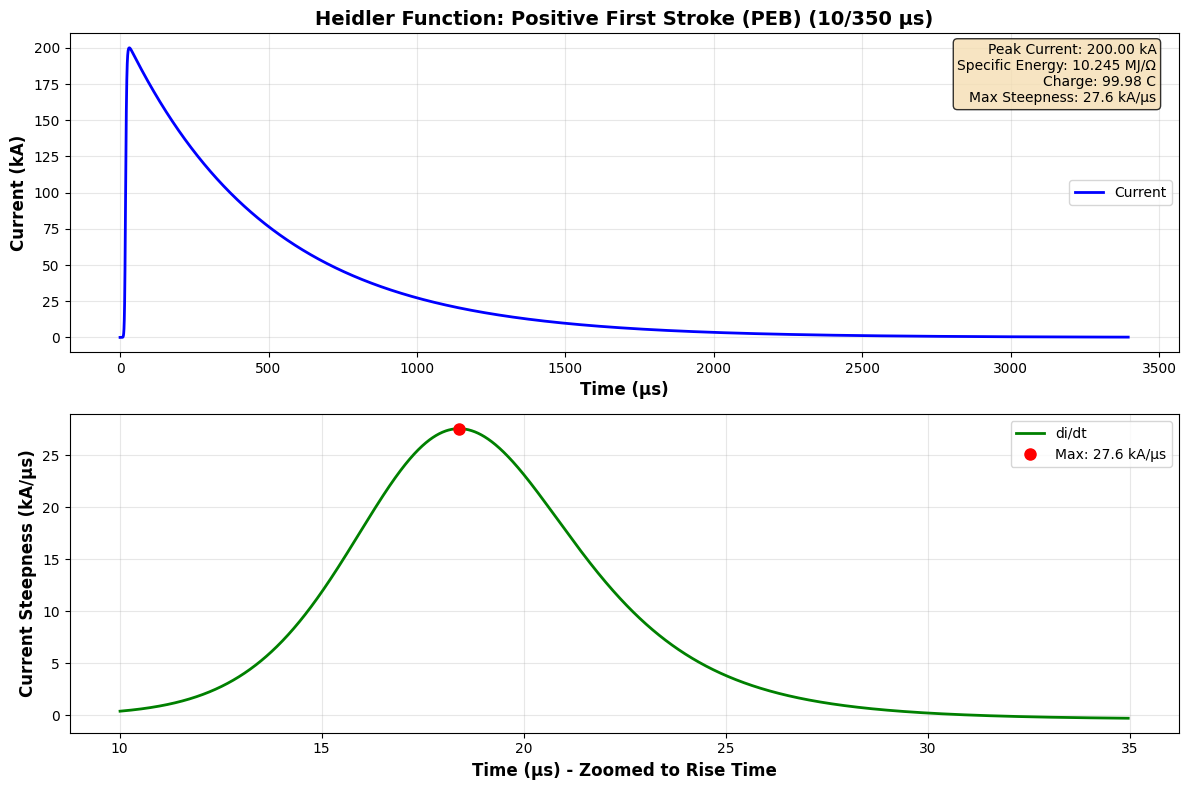

IMPULSE CURRENT CALCULATION RESULTS
Impulse Type: Positive First Stroke (PEB) (10/350 µs)
Peak Current: 200.0 kA
Simulation: Duration=3395.0 µs, Time step=10.0 ns

HEIDLER FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        200.000 kA
  Time to Peak:        31.130 µs
  Specific Energy:     10.2447 MJ/Ω  (10244.69 kJ/Ω)
  Charge:              99.983 C
  Max Steepness:       27.56 kA/µs
  Time of Max di/dt:   18.400 µs

  Reference Values (LPL I):
    Peak Current:      200.0 kA
    Specific Energy:   10.000 MJ/Ω
    Charge:            100.00 C

  Deviations from Reference:
    Peak Current:      +0.00%
    Specific Energy:   +2.45%
    Charge:            -0.02%


In [146]:
# Example matching your imcFAMOS calculation
# Using standard 200 kA first

results_peb_heidler = run_impulse_calculation(
    impulse_type='PEB',
    function_type='heidler',
    I_peak=200e3,  # 200 kA
    duration='infinity',  # 1 ms
    dt=1e-8,  # 10 ns (matching your deltaXVar)
    show_derivative=True
)

### Example 2: Custom Peak Current (282 kA as in your imcFAMOS example)

Auto-calculated duration: 3395.0 µs (7 × tau2)


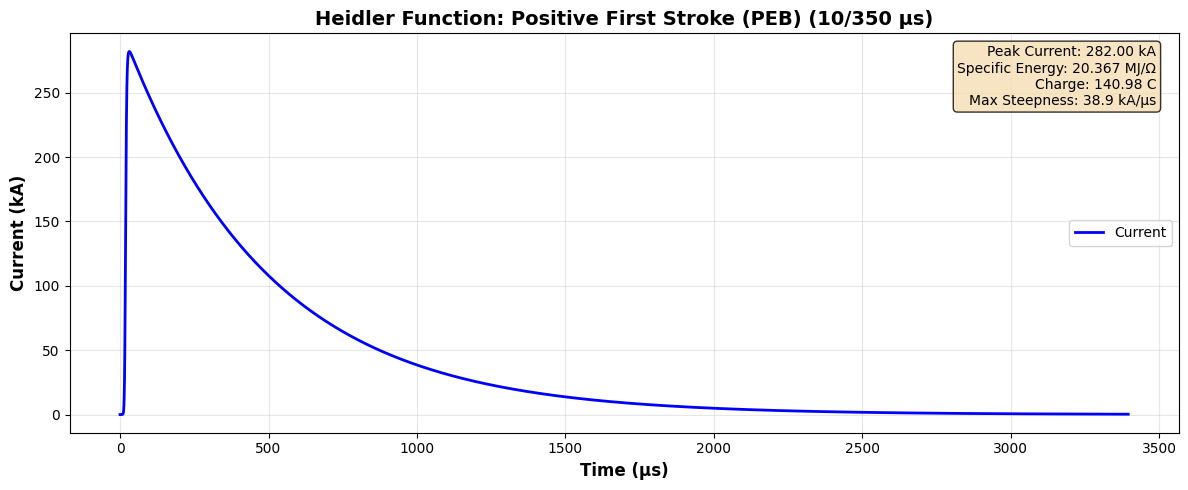

IMPULSE CURRENT CALCULATION RESULTS
Impulse Type: Positive First Stroke (PEB) (10/350 µs)
Peak Current: 282.0 kA
Simulation: Duration=3395.0 µs, Time step=10.0 ns

HEIDLER FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        282.000 kA
  Time to Peak:        31.130 µs
  Specific Energy:     20.3675 MJ/Ω  (20367.48 kJ/Ω)
  Charge:              140.976 C
  Max Steepness:       38.87 kA/µs
  Time of Max di/dt:   18.400 µs

  Reference Values (LPL I):
    Peak Current:      200.0 kA
    Specific Energy:   10.000 MJ/Ω
    Charge:            100.00 C

  Deviations from Reference:
    Peak Current:      +41.00%
    Specific Energy:   +103.67%
    Charge:            +40.98%


In [147]:
# Match your imcFAMOS calculation with 282 kA
results_custom = run_impulse_calculation(
    impulse_type='PEB',
    function_type='heidler',
    I_peak=282e3,  # 282 kA (your ImVar)
    duration='infinity',
    dt=1e-8,
    show_derivative=False
)

### Example 3: Negative First Stroke (1/200 µs) - Both Functions Comparison

Auto-calculated duration: 1995.0 µs (7 × tau2)


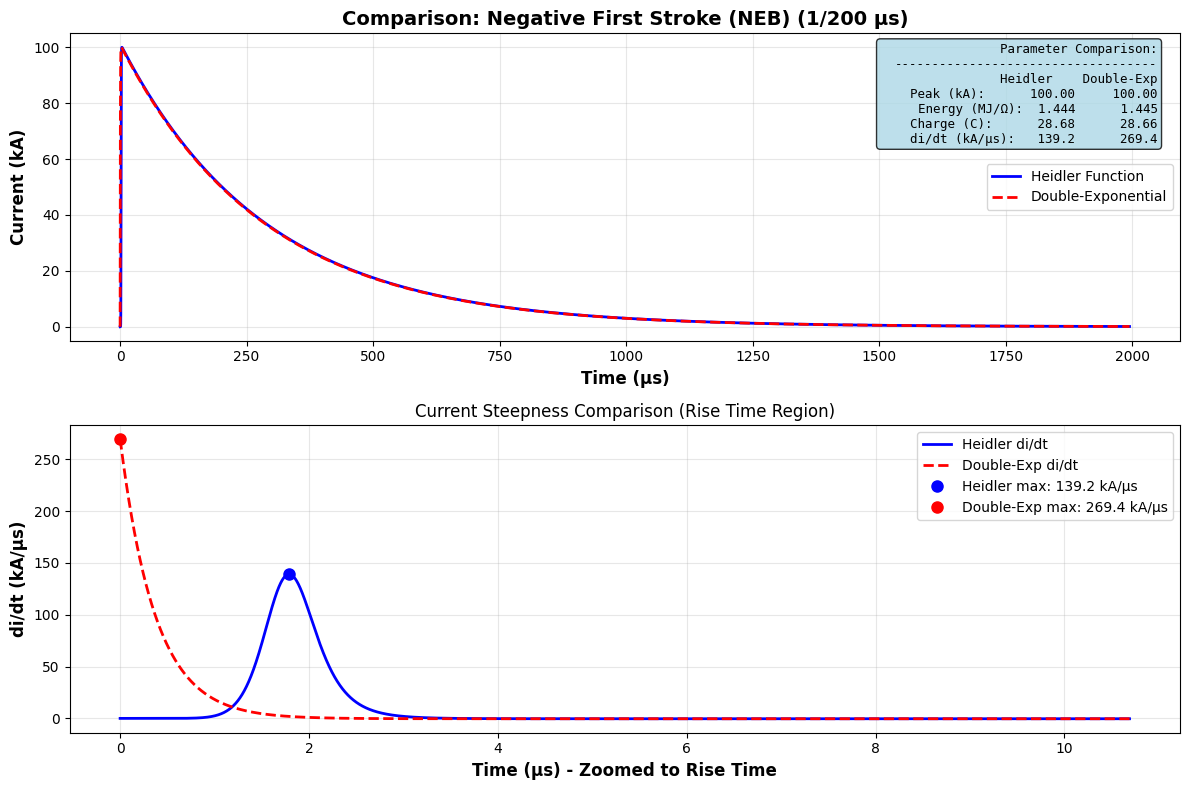

IMPULSE CURRENT CALCULATION RESULTS
Impulse Type: Negative First Stroke (NEB) (1/200 µs)
Peak Current: 100.0 kA
Simulation: Duration=1995.0 µs, Time step=1.0 ns

HEIDLER FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        100.000 kA
  Time to Peak:        3.563 µs
  Specific Energy:     1.4439 MJ/Ω  (1443.90 kJ/Ω)
  Charge:              28.681 C
  Max Steepness:       139.17 kA/µs
  Time of Max di/dt:   1.789 µs

  Reference Values (LPL I):
    Peak Current:      100.0 kA
    Specific Energy:   1.440 MJ/Ω
    Charge:            28.70 C

  Deviations from Reference:
    Peak Current:      +0.00%
    Specific Energy:   +0.27%
    Charge:            -0.07%

DOUBLE EXP FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        100.000 kA
  Time to Peak:        2.484 µs
  Specific Energy:     1.4448 MJ/Ω  (1444.80 kJ/Ω)
  Charge:              28.657 C
  Max Steepness:       2

In [148]:
results_neb_comparison = run_impulse_calculation(
    impulse_type='NEB',
    function_type='both',
    duration='infinity',  # 500 µs
    dt=1e-9,  # 1 ns for faster impulse
    compare_functions_flag=True
)

### Example 4: Negative Subsequent Stroke (0.25/100 µs)

Auto-calculated duration: 1003.8 µs (7 × tau2)


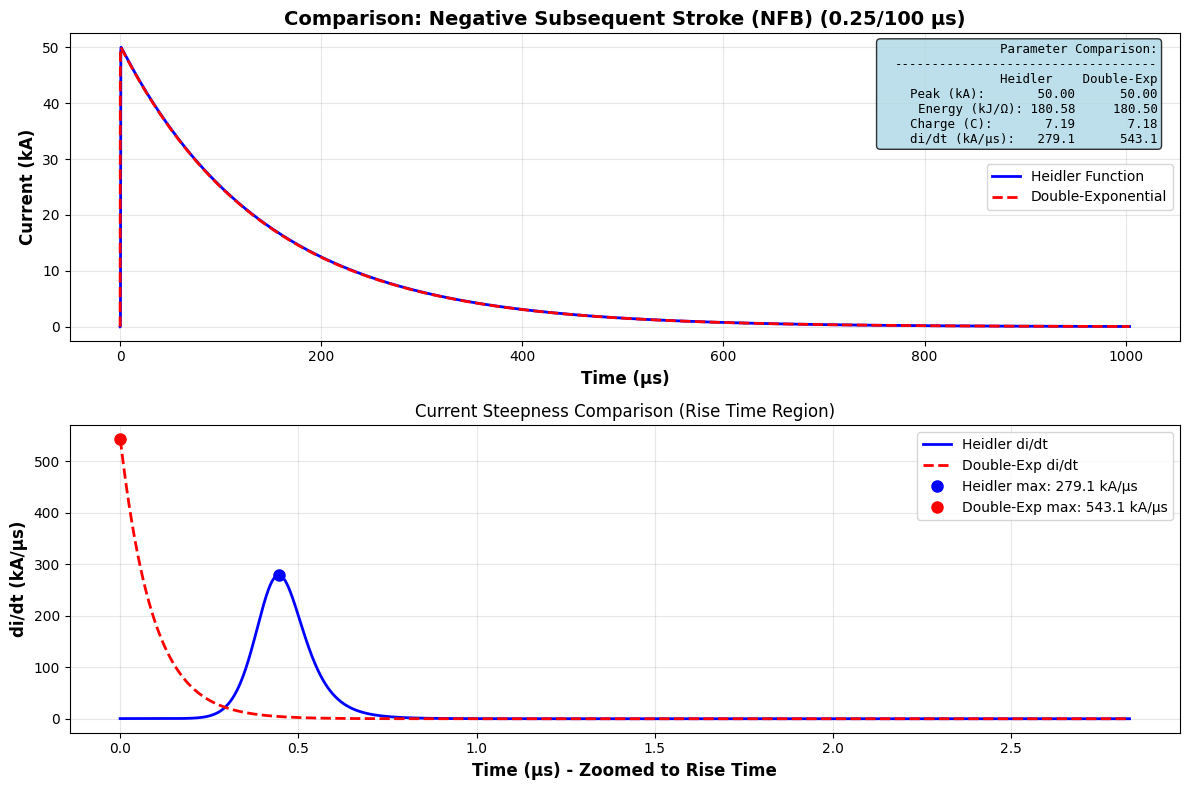

IMPULSE CURRENT CALCULATION RESULTS
Impulse Type: Negative Subsequent Stroke (NFB) (0.25/100 µs)
Peak Current: 50.0 kA
Simulation: Duration=1003.8 µs, Time step=1.0 ns

HEIDLER FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        50.000 kA
  Time to Peak:        0.944 µs
  Specific Energy:     0.1806 MJ/Ω  (180.58 kJ/Ω)
  Charge:              7.192 C
  Max Steepness:       279.09 kA/µs
  Time of Max di/dt:   0.445 µs

  Reference Values (LPL I):
    Peak Current:      50.0 kA
    Specific Energy:   0.180 MJ/Ω
    Charge:            7.20 C

  Deviations from Reference:
    Peak Current:      +0.00%
    Specific Energy:   +0.32%
    Charge:            -0.11%

DOUBLE EXP FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        50.000 kA
  Time to Peak:        0.677 µs
  Specific Energy:     0.1805 MJ/Ω  (180.50 kJ/Ω)
  Charge:              7.184 C
  Max Steepness:       54

In [149]:
results_nfb = run_impulse_calculation(
    impulse_type='NFB',
    function_type='both',
    duration='infinity',  # 300 µs
    dt=1e-9,
    compare_functions_flag=True
)

### Example 5: SEB/SC (8/20 µs) - Surge Current

Auto-calculated duration: 120.0 µs (5 × tau)


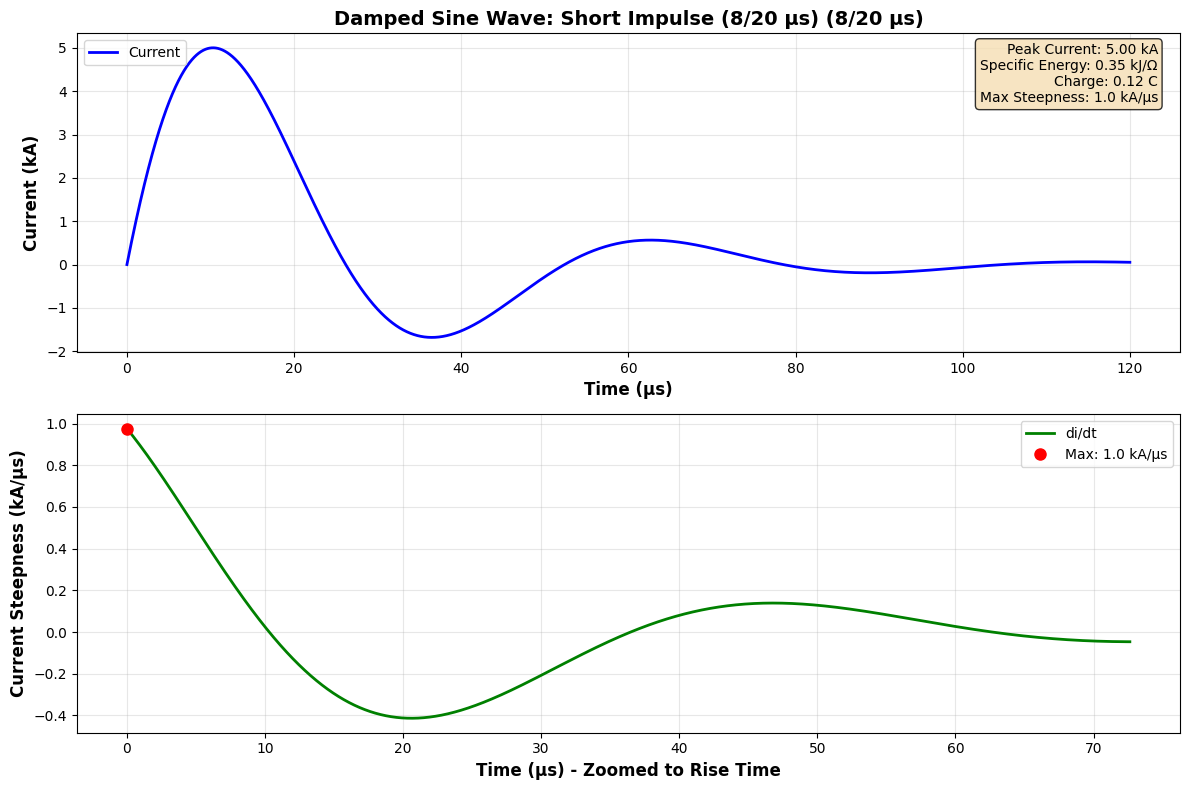

IMPULSE CURRENT CALCULATION RESULTS
Impulse Type: Short Impulse (8/20 µs) (8/20 µs)
Peak Current: 5.0 kA
Simulation: Duration=120.0 µs, Time step=10.0 ns

DAMPED SINE FUNCTION:
--------------------------------------------------------------------------------
  Peak Current:        5.000 kA
  Time to Peak:        10.300 µs
  Specific Energy:     0.0004 MJ/Ω  (0.35 kJ/Ω)
  Charge:              0.121 C
  Max Steepness:       0.98 kA/µs
  Time of Max di/dt:   0.000 µs

  Reference Values (LPL I):
    Peak Current:      10.0 kA
    Specific Energy:   0.050 MJ/Ω
    Charge:            5.00 C

  Deviations from Reference:
    Peak Current:      -50.00%
    Specific Energy:   -99.29%
    Charge:            -97.58%

DEBUG: Charge Calculation Analysis
Positive portion duration: 67.65 µs (6765 points)
Negative portion duration: 52.34 µs (5234 points)

Charge (normal integral ∫i dt):   0.0604 C (should be ~0 for bipolar)
Charge (absolute ∫|i| dt):        0.1208 C
Charge (positive only):           0

In [ ]:
# SEB/SC (8/20 µs) uses damped sine wave: i(t) = (I/eta) * exp(-t/tau) * sin(omega*t)
# Parameters from my old Famos script
# Testing with 15 kA to match network model
# Can use 'SEB' or 'SC' - both work

results_seb = run_impulse_calculation(
    impulse_type='SEB',  # or 'SC' - both work
    function_type='damped_sine',
    I_peak=5e3,          # 15 kA (to match network model)
    duration='infinity',   # Auto-calculate based on tau
    dt=1e-8,              # 10 ns (from Famos: deltaXVar=1e-8)
    show_derivative=True
)

# Debug: Check charge calculation
print("\n" + "="*80)
print("DEBUG: Charge Calculation Analysis")
print("="*80)
t = results_seb['damped_sine']['time']
i = results_seb['damped_sine']['current']

# Check positive and negative portions
i_positive = i[i > 0]
i_negative = i[i < 0]
t_positive_sum = len(i_positive) * (t[1] - t[0])
t_negative_sum = len(i_negative) * (t[1] - t[0])

# Calculate different charge methods
Q_normal = np.trapezoid(i, t)  # Normal integral (should be ~0)
Q_abs = np.trapezoid(np.abs(i), t)  # Absolute value integral
Q_positive_only = np.trapezoid(i[i > 0], t[i > 0])  # Only positive portion

print(f"Positive portion duration: {t_positive_sum*1e6:.2f} µs ({len(i_positive)} points)")
print(f"Negative portion duration: {t_negative_sum*1e6:.2f} µs ({len(i_negative)} points)")
print(f"\nCharge (normal integral ∫i dt):   {Q_normal:.4f} C (should be ~0 for bipolar)")
print(f"Charge (absolute ∫|i| dt):        {Q_abs:.4f} C")
print(f"Charge (positive only):           {Q_positive_only:.4f} C")
print(f"\nExpected from network model:      0.36 C (for 15 kA)")
print(f"Ratio Q_abs / Q_positive:         {Q_abs / Q_positive_only:.3f}")
print("="*80)